# Diabetes Prediction Tool

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter
import os
import joblib

### Modelling Libraries

In [2]:
# sklearn library is used for various machine learning algorithms and models
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### Importing Dataset

In [3]:
dataset = pd.read_csv('diabetes-dataset.csv') 
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Dataset Missing Values Analysis

In [4]:
# Sum zero indicates no missing value in dataset
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

##### There are no missing values in dataset but there are some parameters such as Insulin, SkinThickness, Glucose, Blood Pressure.
##### Zero is not acceptable value for these paramters. 
##### It indicates there are some inconsistancy with dataset

In [5]:
# Identifying zeros in dataset
columns_with_zero = dataset.columns[dataset.eq(0).any()].tolist()
print(columns_with_zero)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Outcome']


##### Replacing zero values wither by mean or median can be decided by presence of outliers in dataset
##### Mean is sensitive to outliers and Median is not
##### Outcome can have 0 and 1 as possible values : 0 - Non-diabetic & 1 - Diabetic
##### Preganancies can also have value 0 hence it can be ignored

In [6]:
# Columns to check outliers
columns_with_zero.remove('Outcome')
columns_with_zero.remove('Pregnancies')
print(columns_with_zero)

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


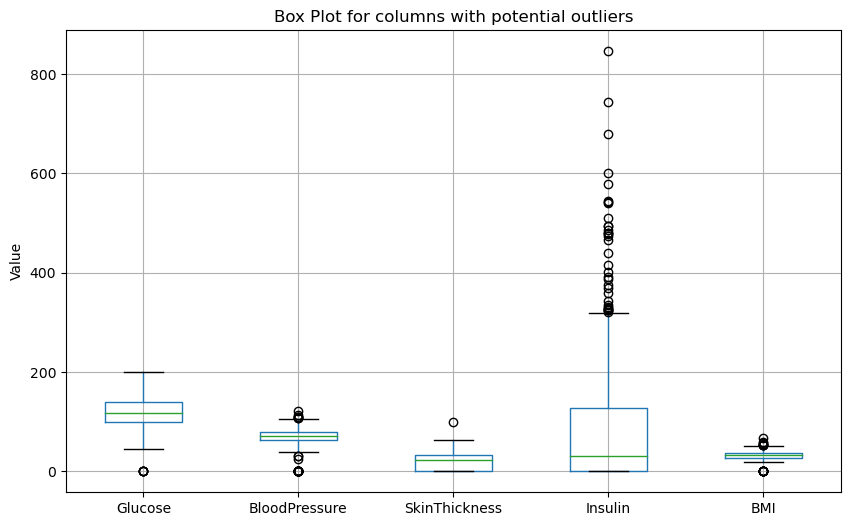

Summary Statistics -
          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   120.894531      69.105469      20.536458   79.799479   31.992578
std     31.972618      19.355807      15.952218  115.244002    7.884160
min      0.000000       0.000000       0.000000    0.000000    0.000000
25%     99.000000      62.000000       0.000000    0.000000   27.300000
50%    117.000000      72.000000      23.000000   30.500000   32.000000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000


In [7]:
summary_stats = dataset[columns_with_zero].describe()
# Boxplot for checking outliers
plot = dataset[columns_with_zero].boxplot(figsize=(10,6))
plot.set_title('Box Plot for columns with potential outliers')
plot.set_ylabel('Value')
#plt.set_xticks(rotation=45)

plt.show()
print("Summary Statistics -")
print(summary_stats)

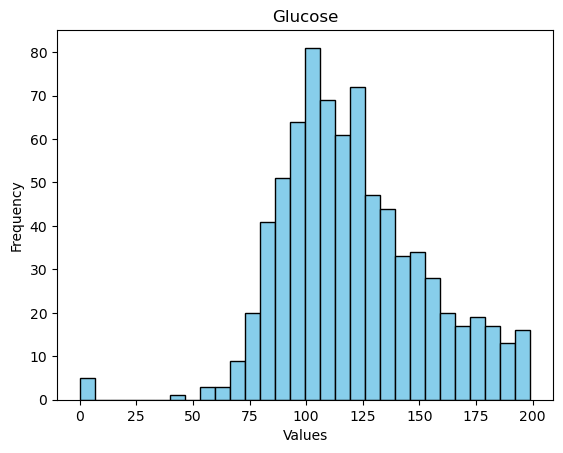

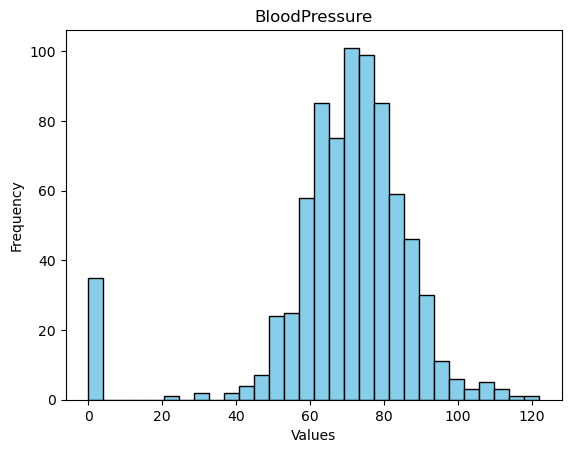

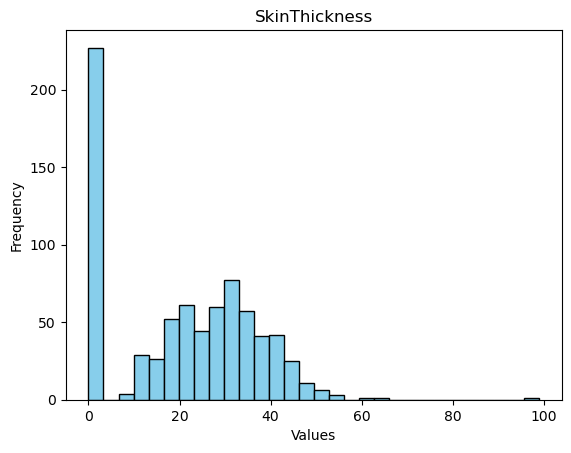

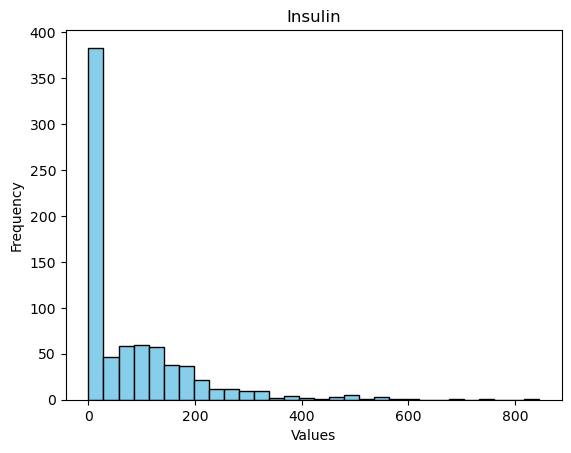

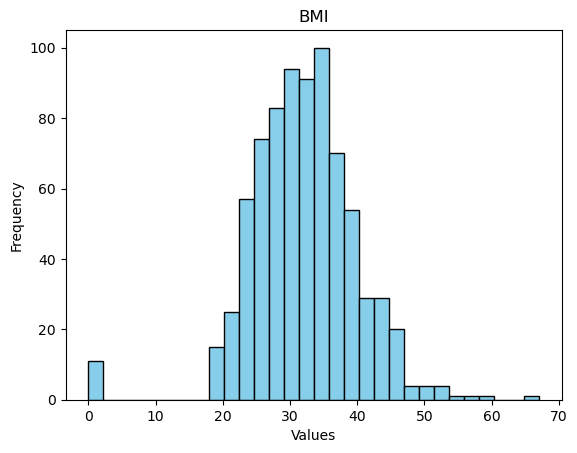

In [8]:
# Histogram for checked data has symmetric distribution or skewed

for values in columns_with_zero:
    plt.hist(dataset[values], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(values)
    plt.show()


##### Replacing zero values with mean for 'Glucose' and 'BloodPressure' because from histogram it looks both of these variables has symmetric distribution

##### Rplacing zero values with median for 'BMI', 'SkinThickness', 'Insulin' bacuse from histogram it looks these variables are right skewed and from boxplot it looks they have lot of outliers

In [9]:
# Replacing zero values of'Glucose' and 'BloodPressure' coulmns with their respective mean
dataset['Glucose'] = dataset['Glucose'].replace(0,dataset['Glucose'].mean())
dataset['BloodPressure'] = dataset['BloodPressure'].replace(0,dataset['BloodPressure'].mean())

# Replacing zer values of'BMI', 'SkinThickness' and 'Insulin' coulmns with their respective median
dataset['BMI'] = dataset['BMI'].replace(0,dataset['BMI'].median())
dataset['SkinThickness'] = dataset['SkinThickness'].replace(0,dataset['SkinThickness'].median())
dataset['Insulin'] = dataset['Insulin'].replace(0,dataset['Insulin'].median())

# Reviwing dataset 
dataset.head()
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


##### Cleaning dataset is complete, now dataset do not have any missing values 
##### Using heatmap to find co-relation of Outcome with parameters 

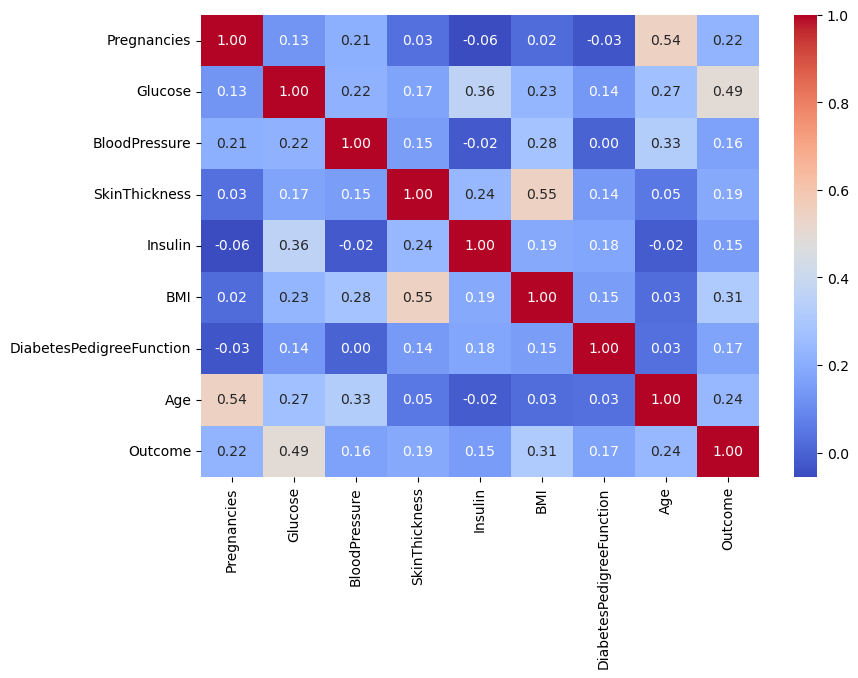

In [10]:
# Plotting heatmap
plt.figure(figsize = (9,6))
sb.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()
#print(dataset.corr())

In [12]:
# If heatmap do not show values of correlation martix - Update seaborn and matplotlib libraries
# pip install --upgrade seaborn matplotlib

##### Heatmap illustrates that - Glucose (0.49), BMI (0.31), Age(0.24), Pregnancies(0.22) are more co-related with outcome
##### Exploring Glucose, BMI, Age, Pregnancies Vs Outcome

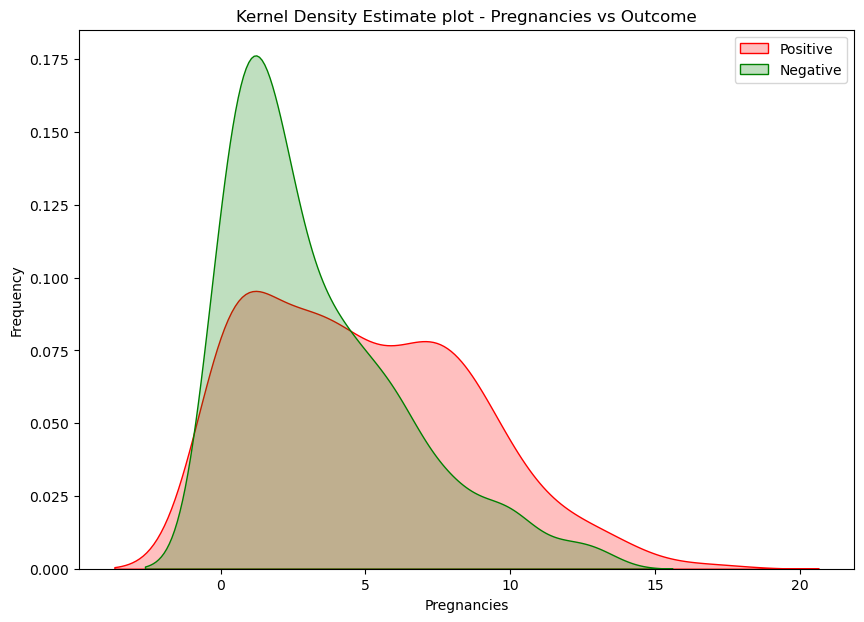

In [11]:
# Exploring Pregnancies Vs Outcome
plt.figure(figsize=(10,7))
p = sb.kdeplot(dataset["Pregnancies"][dataset["Outcome"] == 1], color="Red", fill=True)
p = sb.kdeplot(dataset["Pregnancies"][dataset["Outcome"] == 0], ax=p, color="Green", fill=True)
p.set_xlabel("Pregnancies")
p.set_ylabel("Frequency")
p.legend(["Positive","Negative"])
plt.title("Kernel Density Estimate plot - Pregnancies vs Outcome")
plt.show()

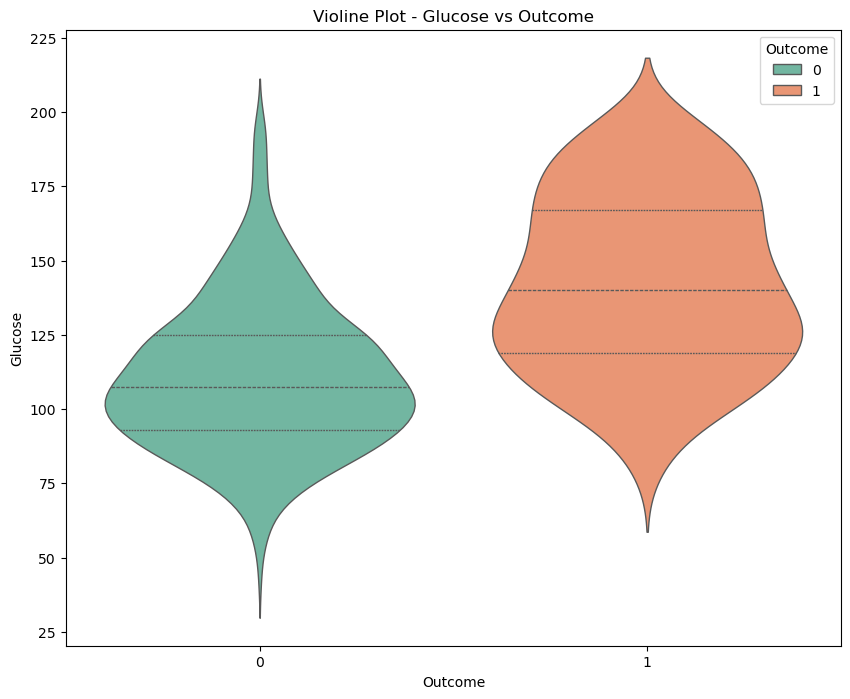

In [12]:
#Explore Glucose vs Outcome
plt.figure(figsize=(10,8))
sb.violinplot(data=dataset,x="Outcome",y="Glucose",inner="quart",linewidth=1,hue="Outcome",palette="Set2")
plt.title("Violine Plot - Glucose vs Outcome")
plt.show()

##### From above violin plot diabetes increases with increase in glucose level
##### Outcome 0 referes to Non-Diabetic and 1 refers to Diabetic

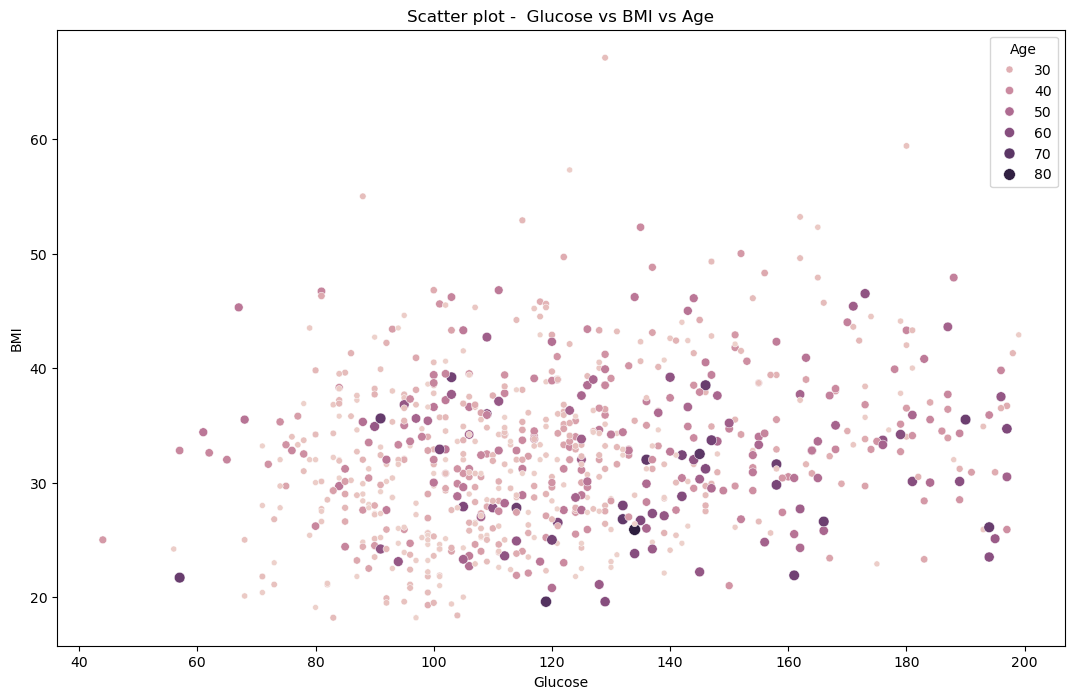

In [13]:
# Explore Glucose vs BMI vs Age
plt.figure(figsize=(13,8))
sb.scatterplot(data= dataset, x="Glucose",y="BMI", hue="Age",size="Age")
plt.title("Scatter plot -  Glucose vs BMI vs Age")
plt.show()

##### There are some outliers in above scattered plot
##### Need to remove these outliers because they can affect negatively on traning process of algorithm and can impact accuracy of machine learning model
##### To identify outliers using Tukey Method

In [14]:
# Function detecting outliers
def detect_outliers(df,n,features):
    """ This function detects outliers from given features
        It returns a list of indices """
    #print(features)
    for col in features:
        outlier_indices = []
        # First Quartile
        Q1 = np.percentile(df[col],25)
        #print(Q1)
        # Third Quartile
        Q3 = np.percentile(df[col],75)
        #print(Q3)
        # Interquartile Range
        IQR = Q3 - Q1
        #print(IQR)
        # Outlier step
        outlier_step = 1.5*IQR
        #print(outlier_step)
        # List of outlier indices
        #print(col)
        outliers_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        #print(outliers_list_col)
        # Appending outlier indices
        outlier_indices.extend(outliers_list_col)
        #print(outlier_indices)
        # Select observations containing more than two outliers
        outlier_indices = Counter(outlier_indices)
        #print(outlier_indices)
        multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

# Detecting outliers
outlier_to_drop = detect_outliers(dataset, 2, ["Pregnancies", "Glucose", "BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction"
                                              ,"Age"])

#print(outlier_to_drop)
dataset.drop(dataset.loc[outlier_to_drop].index, inplace=True)

##### Splitting the dataset into training and test dataset

## Modeling
##### Transforming data into quartile using sklearn.processing module

In [15]:
# Data Transformation
# Create instance of QuantileTransformer class
q = QuantileTransformer(n_quantiles=768) # 768 data samples in dataset
# Fits quantile transform for dataset
x = q.fit_transform(dataset)
# Transforms data 'x' using quantile transformer 'q'
transformedDF = q.transform(x)
# Converts array into DataFrame using Pandas library
transformedDF = pd.DataFrame(x)
# Sets column names of DataFrame matches with original dataset
transformedDF.columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
# Displays first few lines of DataFrame
transformedDF.head()

/opt/miniconda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.747718,0.810300,0.516949,0.801825,0.256193,0.591265,0.750978,0.889831,1.0
1,0.232725,0.091265,0.290091,0.644720,0.256193,0.213168,0.475880,0.558670,0.0
2,0.863755,0.956975,0.233377,0.357888,0.256193,0.077575,0.782269,0.585398,1.0
3,0.232725,0.124511,0.290091,0.357888,0.662973,0.284224,0.106258,0.000000,0.0
4,0.000000,0.721643,0.005215,0.801825,0.834420,0.926988,0.997392,0.606258,1.0


##### Splitting data into test and train
##### Train data will be used in model traning
##### Test data will be used in prediction
##### Splitting dataset in 70% train data and 30% test data

In [16]:
features = dataset.drop(["Outcome"], axis=1)
labels = dataset["Outcome"]

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

## Cross Validating Models

### 1. Logestic Regression
### 2. Random Forest

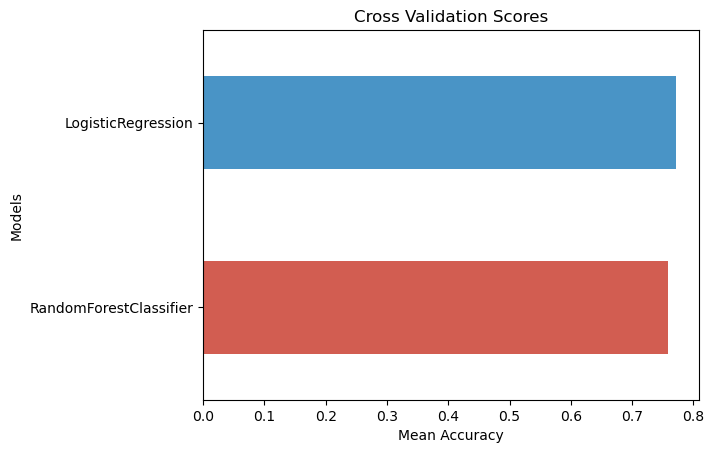

,CrossValMeans,CrossValErrors,Models
0,0.770929,0.044053,LogisticRegression
1,0.757897,0.050522,RandomForestClassifier


In [17]:
def evaluate_model(models,custom_colors):
    """ This function takes list of models and returns the 
    chart of cross validation scores using mean accuracy """

    result = []
    cv_means = []
    cv_std = []
    
    # cross validate model with k fold stratified cross value
    kfold = StratifiedKFold(n_splits = 10)
    
    for model in models:
        result.append(cross_val_score(estimator = model, X = x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs = 4))
        
    for cv_result in result:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans" : cv_means,
        "CrossValErrors" : cv_std,
        "Models" : ["LogisticRegression", "RandomForestClassifier"]
    })

    # Generate Chart
    bar = sb.barplot(x = "CrossValMeans", y = "Models", data = result_df, orient = "h",palette=custom_colors, 
                     width=0.5 , hue="Models", dodge=False, legend=False)
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross Validation Scores")
    plt.show()
    return result_df

random_state = 30
models = [
    LogisticRegression(random_state = random_state, solver = 'liblinear'),
    RandomForestClassifier(random_state = random_state)
]

# Define custom colors
custom_colors = ["#3498db", "#e74c3c"]  # Add more colors if you have more models

# This function takes input as list of models and returns chart of cross validation scores
evaluate_model(models,custom_colors)

## Hyperparameter Tunning

#### Hyperparameter tunning is choosing set of optimal hyperparameters for learning algorithm 
#### It is model argument whose value is set before learning process begins

### Tunning Process

In [18]:
def analyse_grid_result(grid_result):
    """ Analysis of GridCV result and predicting with test dataset 
    show classification report"""
    # Best parameter for accuracy
    print("Tunned hyperparameter : (best parameters) ", grid_result.best_params_)
    print("Accuracy :", grid_result.best_score_)

    means = grid_result.cv_results_["mean_test_score"]
    stds = grid_result.cv_results_["std_test_score"]
    for means, std, params in zip(means, stds, grid_result.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (means, std * 2, params))
        print()
        print("Detailed Classification Report")
        y_true, y_pred = y_test, grid_result.predict(x_test)
        print(classification_report(y_true, y_pred))
        print()

### Tunning for Logestic Regression

In [21]:
# Defining model and parameters for logesticRegression
model = LogisticRegression(solver = 'liblinear')
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Define grid search
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = StratifiedKFold(n_splits = 50, random_state = 1, shuffle = True) 
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = cv, scoring = 'accuracy', error_score = 0)
logi_result = grid_search.fit(x_train, y_train)

# LogisticRegression Hyperparameter Result
analyse_grid_result(logi_result)

Tunned hyperparameter : (best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.7774545454545455
0.772 (+/-0.210) for {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

Detailed Classification Report
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       151
           1       0.62      0.57      0.60        80

    accuracy                           0.73       231
   macro avg       0.70      0.69      0.70       231
weighted avg       0.73      0.73      0.73       231


0.772 (+/-0.210) for {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

Detailed Classification Report
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       151
           1       0.62      0.57      0.60        80

    accuracy                           0.73       231
   macro avg       0.70      0.69      0.70       231
weighted avg       0.73      0.73      0.73       231


0.772 (+/-0.

### Tunning for RandomForest Classifier

In [22]:
# Defining model and parameters for RandomForestClassifier
model = RandomForestClassifier(random_state = 42)

# Define Grid Search
tunned_parameters = {
    'n_estimators' : [200, 500],
    'max_features' : ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' : ['gini', 'entropy']
}

cv = StratifiedKFold(n_splits = 2, random_state = 1, shuffle = True) 
grid_search = GridSearchCV(estimator = model, param_grid = tunned_parameters, cv = cv, scoring = 'accuracy', error_score = 0)
rand_result = grid_search.fit(x_train, y_train)

# RandomForestClassifier Hyperparameter Result
analyse_grid_result(rand_result)

Tunned hyperparameter : (best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}
Accuracy : 0.7840051600732398
0.771 (+/-0.018) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}

Detailed Classification Report
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       151
           1       0.62      0.60      0.61        80

    accuracy                           0.73       231
   macro avg       0.70      0.70      0.70       231
weighted avg       0.73      0.73      0.73       231


0.773 (+/-0.014) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}

Detailed Classification Report
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       151
           1       0.62      0.60      0.61        80

    accuracy                           0.73       231
   macro avg       0.70   

### RandomForestClassifier model gives 78.40% accuracy and LogesticRegression model gives 77.74% accuracy

# Selecing RandomForestClassifier model for Diabetes Prediction

### Saving the trained RandomForestClassifier model to a file using joblib

In [23]:
# Get the best parameters and the best score
best_params = rand_result.best_params_
best_score = rand_result.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Get the best estimator (model)
best_model = rand_result.best_estimator_

best_model.fit(x_train, y_train)

# Save the trained model to a file using joblib
joblib.dump(best_model, 'random_forest_model.pkl')

Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}
Best Score: 0.7840051600732398


['random_forest_model.pkl']

In [27]:
model = joblib.load('./random_forest_model.pkl')

# Test the model with some sample data
sample_data = np.array([[6,148,72,35,0,33.6,0.627,50]])  # Replace with appropriate test values
prediction = model.predict(sample_data)
print('Prediction:', prediction)
print(best_model)

Prediction: [1]
RandomForestClassifier(max_depth=6, n_estimators=500, random_state=42)


/opt/miniconda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
